# 6.6 通过时间反向传播

裁剪梯度为了应对梯度衰减或爆炸，如果不裁剪梯度，模型将无法正常训练。为了深刻理解这一现象，本节将介绍循环神经网络中梯度的计算和存储方法，即通过时间反向传播（back-propagation through time）。

我们在正向传播、反向传播和计算图中介绍了神经网络中梯度计算与存储的一般思路，并强调正向传播和反向传播相互依赖。正向传播在循环神经网络中比较直观，而通过时间反向传播其实是反向传播在循环神经网络中的具体应用。我们需要将循环神经网络按时间步展开，从而得到模型变量和参数之间的依赖关系，并依据链式法则应用反向传播计算并存储梯度。

## 6.6.1 定义模型

我们考虑一个无偏差项的循环神经网络，且激活函数为恒等映射($\phi(x)=x$)。设时间步$x$的输入为单样本$x_t 
\in \mathbb R^{d}$，标签为$y_t$，那么隐藏状态$h_t \in \mathbb R^{h}$的计算表达式为:

$$h_t=W_{hx}x_t+W_{hh}h_{t-1},$$

其中$W_hx \in \mathbb R^{h \times d}$和$W_{hh}\in \mathbb R^{h \times h}$是隐藏层权重参数。设输出层权重参数$W_{q \times h}$,时间步t的输出层变量$o_t \in \mathbb R^q$计算为：

$$o_t=W_{qh}h_t$$

设时间步$t$的损失为:$\iota (o_t,y_t)$。时间步数为T的损失函数L定义为：$$L=\frac{1}{T}\sum_{t=1}^{T}\iota (o_t,y_t)$$
我们将L称为有关给定时间步的数据样本的目标函数。

## 6.6.2 模型计算图

为了可视化循环神经网络中模型变量和参数在计算中的依赖关系，我们可以绘制模型计算图，如图6.3所示。例如，时间步3的隐藏状态$h_3$的计算依赖模型参数$W_{hx}$、$W_{hh}$、上一时间步隐藏状态$h2$以及当前时间步输入$x3$。

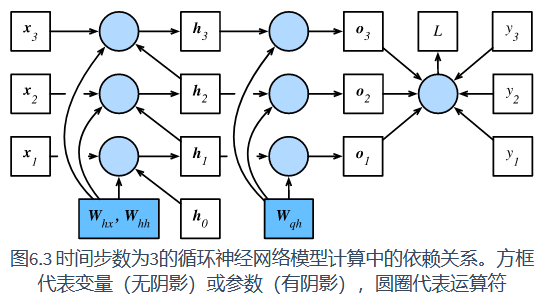

## 6.6.3 方法

图6.3中的模型的参数是$W_{hx}$, $W_{hh}$ 和 $W_{qh}$。与3.14节（正向传播、反向传播和计算图）中的类似，训练模型通常需要模型参数的梯度$\frac{\partial L}{\partial W_{hx}}$、$\frac{\partial L}{\partial W_{hh}}$和$\frac{\partial L}{\partial W_{qh}}$。 根据图6.3中的依赖关系，我们可以按照其中箭头所指的反方向依次计算并存储梯度。为了表述方便，我们依然采用3.14节中表达链式法则的运算符prod。

首先，目标函数有关各时间步输出层变量的梯度$\frac{\partial L}{\partial o_{t}}$很容易计算：

$$\frac{\partial L}{\partial o_{t}}=\frac{\partial \iota (o_t,y_t)}{T\cdot \partial o_t}$$


我们可以计算目标函数有关模型参数$W_{qh}$的梯度$\frac{\partial L}{\partial W_{qh}}\in \mathbb R^{q×h}$。根据图6.3，$L$通过$o_1,...o_T$依赖$W_{qh}$。依据链式法则，

$$\frac{\partial L}{\partial W_{qh}}=\sum_{t=1}^{T}prod(\frac{\partial L}{\partial o_t},\frac{\partial o_t}{\partial W_{qh}})=\sum_{t=1}^{T} \frac{\partial L}{\partial o_t}h_t^{T}$$


其次，我们注意到隐藏状态之间也存在依赖关系。 在图6.3中，$L$只通过$o_T$依赖最终时间步$T$的隐藏状态$h_T$。因此，我们先计算目标函数有关最终时间步隐藏状态的梯度$\frac{\partial L}{\partial h_T}$。依据链式法则，我们得到:

$$\frac{\partial L}{\partial h_T}=prod(\frac{\partial L}{\partial o_t},\frac{\partial o_t}{\partial h_T})=W^{T}_{qh}\frac{\partial L}{\partial o_T}$$

接下来对于时间步$t<T$, 在图6.3中，$L$通过$h_{t+1}$和$o_t$依赖$h_t$。依据链式法则，目标函数有关时间步$t<T$的隐藏状态的梯度$\frac{\partial L}{\partial h_t}\in \mathbb R^{h}$需要按照时间步从大到小依次计算：

$$\frac{\partial L}{\partial h_t}=prod(\frac{\partial L}{\partial h_{t+1}},\frac{\partial h_{t+1}}{\partial h_t})+prod(\frac{\partial L}{\partial o_t},\frac{\partial o_t}{\partial h_t})=W^{T}_{hh}\frac{\partial L}{\partial h_{t+1}}+W^{T}_{qh}\frac{\partial L}{\partial o_t}$$

将上面的递归公式展开，对任意时间步$1≤t≤T$，我们可以得到目标函数有关隐藏状态梯度的通项公式:$$\frac{\partial L}{\partial h_t}=\sum_{i=t}^{T}(W^{T}_{hh})^{T-i}W^{T}_{qh}\frac{\partial L}{\partial o_{T+t-i}}$$

由上式中的指数项可见，当时间步数$T$较大或者时间步$t$较小时，目标函数有关隐藏状态的梯度较容易出现衰减和爆炸。这也会影响其他包含$\frac{\partial L}{\partial h_t}$项的梯度，例如隐藏层中模型参数的梯度$\frac{\partial L}{\partial W_{hx}}\in \mathbb R^{h \times d}$和$\frac{\partial L}{\partial W_{hh}}\in \mathbb R^{h \times h}$。 在图6.3中，$L$通过$h_1,…,h_T$依赖这些模型参数。 依据链式法则，我们有:
$$\frac{\partial L}{\partial W_{hx}}=\sum_{t=1}^{T}prod(\frac{\partial L}{\partial h_t},\frac{\partial h_t}{\partial W_{hx}})=\sum_{t=1}^{T}\frac{\partial L}{\partial h_t}x_t$$

$$\frac{\partial L}{\partial W_{hh}}=\sum_{t=1}^{T}prod(\frac{\partial L}{\partial h_t},\frac{\partial h_t}{\partial W_{hh}})=\sum_{t=1}^{T}\frac{\partial L}{\partial h_t}h_{t-1}^T$$

每次迭代中，我们在依次计算完以上各个梯度后，会将它们存储起来，从而避免重复计算。例如，由于隐藏状态梯度$\frac{\partial L}{\partial h_t}$被计算和存储，之后的模型参数梯度$\frac{\partial L}{\partial W_{hx}}$和$\frac{\partial L}{\partial W_{hh}}$的计算可以直接读取$\frac{\partial L}{\partial h_t}$重复计算它们。此外，反向传播中的梯度计算可能会依赖变量的当前值。它们正是通过正向传播计算出来的。 举例来说，参数梯度$\frac{\partial L}{\partial W_{hh}}$的计算需要依赖隐藏状态在时间步$t=0,…,T−1$的当前值$h_t$（$h_0$是初始化得到的）。这些值是通过从输入层到输出层的正向传播计算并存储得到的。